In [1]:
#SVM MODEL 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dilki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Predefined list of network-specific stopwords
network_stopwords = set([
    'seq', 'win', 'len', 'ack', 'udp', 'tcp', 'flags', 'ttl', 'id', 'offset', 'tos', 'length', 
    'info', 'dst', 'src', 'protocol', 'version', 'ihl', 'checksum', 'options', 'urg', 'psh', 'rst', 
    'syn', 'fin', 'payload', 'data', 'options', 'mac', 'ethernet', 'frame', 'srcport', 'dstport', 
    'tcpflags', 'ttl', 'id', 'offset', 'tos', 'flags', 'time', 'sport', 'dport'
])


In [3]:
# Including standard stopwords as well
stopwords = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 
    'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 
    'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
    'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 
    'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
    'should', 'now'
]).union(network_stopwords)

In [4]:
# Including standard stopwords as well
all_stopwords = set(nltk_stopwords.words('english')).union(network_stopwords)

In [5]:
# Importing the dataset
dataset = pd.read_csv('dataset - Copy (2).tsv', delimiter='\t', quoting=3)

In [6]:
# Sample a smaller subset of the dataset for more realistic results
dataset = dataset.sample(n=500, random_state=0).reset_index(drop=True)

In [7]:
# Initialize an empty list to store the logs
corpus = []
ps = PorterStemmer()

# Loop through each row in the dataset
for i in range(len(dataset)):
    info = dataset['Info'][i]
    
    # Convert non-string values to strings and handle NaNs
    if pd.isnull(info):
        info = ''
    else:
        info = str(info)
    
    # Clean the log
    log = re.sub('[^a-zA-Z0-9]', ' ', info)
    log = log.lower()
    log = log.split()
    
    # Remove stopwords and apply stemming
    log = [ps.stem(word) for word in log if word not in stopwords]
    
    # Join the words back into a single string
    log = ' '.join(log)
    
    # Append the cleaned log to the corpus
    corpus.append(log)

In [8]:
# Creating the Bag of Words model
cv = CountVectorizer(max_features=1000)
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, 1].values

In [9]:
# Splitting the dataset into the Training set, Validation set, and Test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0, stratify=y_train_val)

In [10]:
# Training the original SVM model with different initial parameters to prevent overfitting
svm_classifier_original = SVC(kernel='linear', C=0.01, gamma='scale', random_state=0)
svm_classifier_original.fit(X_train, y_train)

SVC(C=0.01, kernel='linear', random_state=0)

In [11]:
# Predicting the Validation set results with the original SVM model
svm_y_pred_original = svm_classifier_original.predict(X_val)

In [12]:
# Evaluating the original SVM model
svm_accuracy_original = accuracy_score(y_val, svm_y_pred_original)
svm_precision_original = precision_score(y_val, svm_y_pred_original, average='binary')
svm_recall_original = recall_score(y_val, svm_y_pred_original)
svm_f1_original = f1_score(y_val, svm_y_pred_original, average='binary')

In [13]:
# Displaying the results for the original SVM model
print("Original SVM Model")
print(f"Accuracy: {svm_accuracy_original:.4f}")
print(f"Precision: {svm_precision_original:.4f}")
print(f"Recall: {svm_recall_original:.4f}")
print(f"F1 Score: {svm_f1_original:.4f}")

Original SVM Model
Accuracy: 0.7500
Precision: 0.7500
Recall: 1.0000
F1 Score: 0.8571


In [14]:
# Defining a broader parameter grid for hyperparameter tuning
param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

In [15]:
# Performing RandomizedSearchCV with more iterations and folds to find the best hyperparameters
random_search = RandomizedSearchCV(SVC(random_state=0), param_distributions=param_dist, n_iter=50, cv=10, scoring='accuracy', n_jobs=-1, random_state=0)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=SVC(random_state=0), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100],
                                        'gamma': [0.001, 0.01, 0.1, 1],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=0, scoring='accuracy')

In [16]:
# Extracting the best parameters
best_params = random_search.best_params_

In [17]:
# Training the optimized SVM model with the best hyperparameters on the training set
svm_classifier_optimized = SVC(**best_params, random_state=0)
svm_classifier_optimized.fit(X_train, y_train)

SVC(C=1, gamma=1, kernel='poly', random_state=0)

In [18]:
# Predicting the Validation set results with the optimized model
svm_y_pred_optimized = svm_classifier_optimized.predict(X_val)

In [19]:
# Evaluating the optimized SVM model on the validation set
svm_accuracy_optimized = accuracy_score(y_val, svm_y_pred_optimized)
svm_precision_optimized = precision_score(y_val, svm_y_pred_optimized, average='binary')
svm_recall_optimized = recall_score(y_val, svm_y_pred_optimized)
svm_f1_optimized = f1_score(y_val, svm_y_pred_optimized, average='binary')
svm_cm_optimized = confusion_matrix(y_val, svm_y_pred_optimized)

# Displaying the results for the optimized model
print("\nOptimized SVM Model")
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {svm_accuracy_optimized:.4f}")
print(f"Precision: {svm_precision_optimized:.4f}")
print(f"Recall: {svm_recall_optimized:.4f}")
print(f"F1 Score: {svm_f1_optimized:.4f}")


Optimized SVM Model
Best Parameters: {'kernel': 'poly', 'gamma': 1, 'C': 1}
Accuracy: 0.9800
Precision: 0.9740
Recall: 1.0000
F1 Score: 0.9868


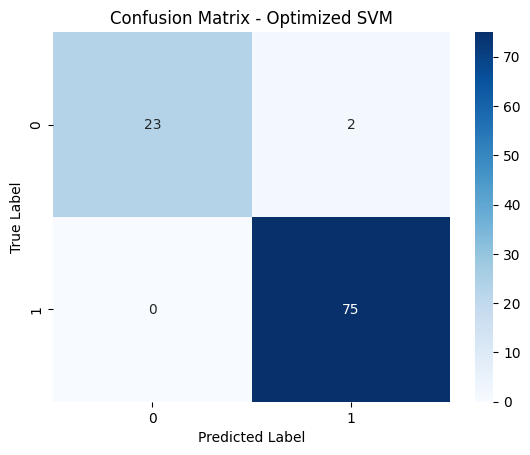

In [20]:
# Visualizing the confusion matrix of the optimized model as a heatmap
sns.heatmap(svm_cm_optimized, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Optimized SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [21]:
# Dumping the trained optimized model to a file
#joblib.dump(svm_classifier_optimized, 'svm_model_optimized.joblib')

In [22]:
# Dumping the CountVectorizer
#joblib.dump(cv, 'count_vectorizer.joblib')

Data Visualization

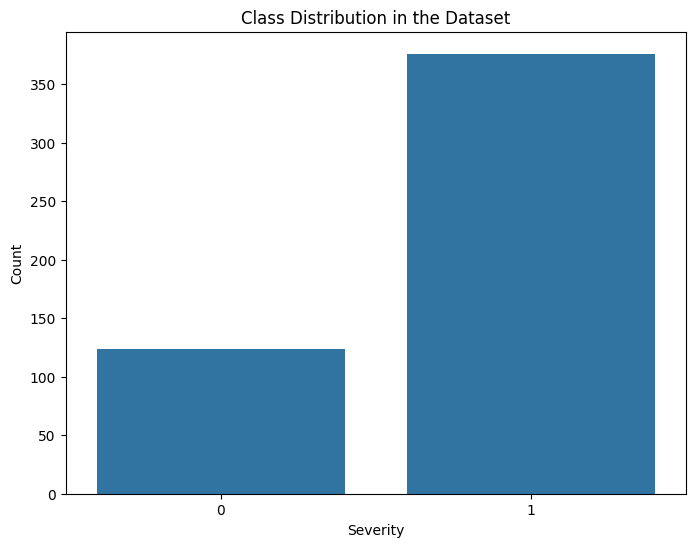

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Class distribution visualization
plt.figure(figsize=(8, 6))
sns.countplot(x=dataset.iloc[:, 1])
plt.title('Class Distribution in the Dataset')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


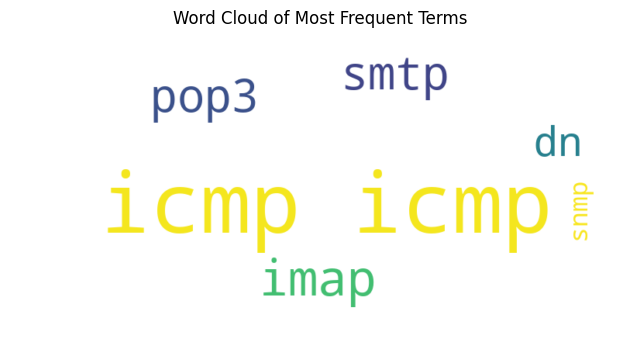

In [24]:
#Word Cloud: Generate a word cloud to visualize the most frequent terms in the corpus.
!pip install wordcloud
from wordcloud import WordCloud

# Join all corpus texts
all_words = ' '.join(corpus)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Terms')
plt.show()


Found existing installation: scikit-learn 1.5.1
Uninstalling scikit-learn-1.5.1:
  Successfully uninstalled scikit-learn-1.5.1


You can safely remove it manually.


Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.5.1-cp312-cp312-win_amd64.whl.metadata (12 kB)
Using cached scikit_learn-1.5.1-cp312-cp312-win_amd64.whl (10.9 MB)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


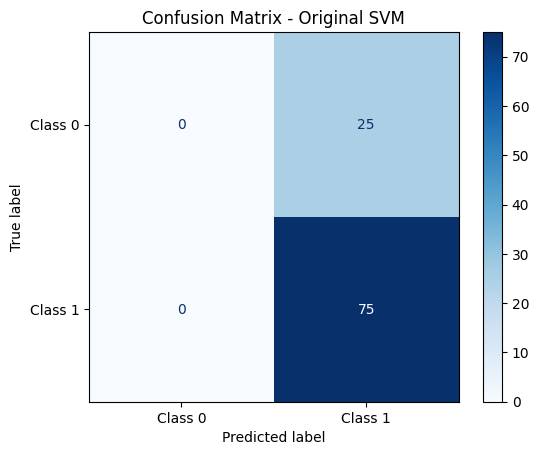

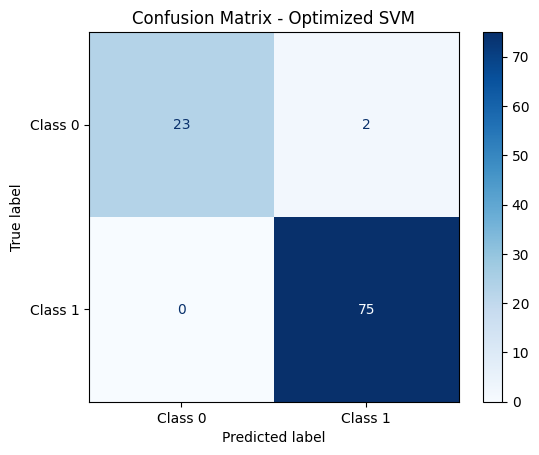

In [25]:
#Confusion Matrix: Visualize the confusion matrix for both the original and optimized SVM models.
# Upgrade scikit-learn
!pip uninstall scikit-learn -y
!pip install scikit-learn

# Import necessary libraries
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have your SVM classifiers and validation data ready
# svm_classifier_original, svm_classifier_optimized, X_val, y_val

# Plot confusion matrix for the original SVM model
ConfusionMatrixDisplay.from_estimator(svm_classifier_original, X_val, y_val, display_labels=['Class 0', 'Class 1'], cmap='Blues')
plt.title('Confusion Matrix - Original SVM')
plt.show()

# Plot confusion matrix for the optimized SVM model
ConfusionMatrixDisplay.from_estimator(svm_classifier_optimized, X_val, y_val, display_labels=['Class 0', 'Class 1'], cmap='Blues')
plt.title('Confusion Matrix - Optimized SVM')
plt.show()


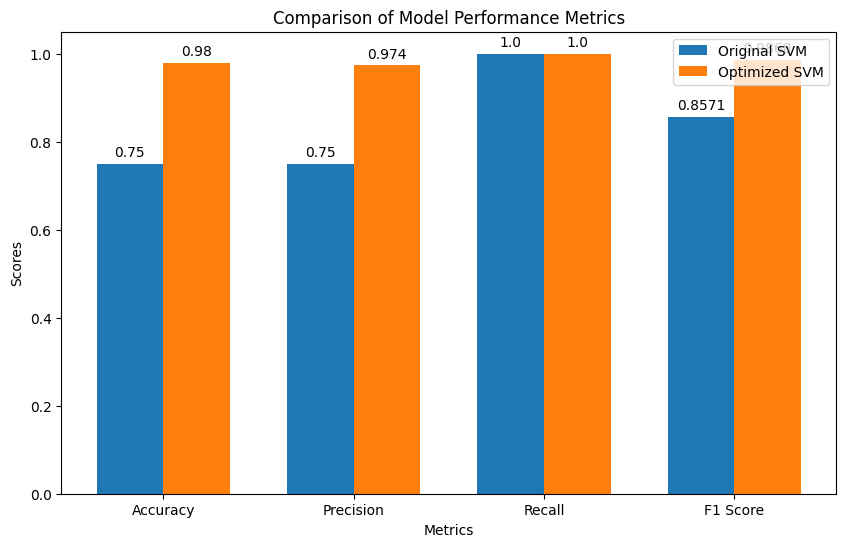

In [26]:
#Model Performance: Visualize the performance metrics of both models.
import numpy as np

# Data for bar plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
original_scores = [svm_accuracy_original, svm_precision_original, svm_recall_original, svm_f1_original]
optimized_scores = [svm_accuracy_optimized, svm_precision_optimized, svm_recall_optimized, svm_f1_optimized]

# Bar plot for model performance comparison
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, original_scores, width, label='Original SVM')
bars2 = ax.bar(x + width/2, optimized_scores, width, label='Optimized SVM')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar displaying its height
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate('{}'.format(round(height, 4)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()
